# **Preamble**

## Imports

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from collections import defaultdict, Counter
import pandas as pd
import subprocess 
import re
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score, mutual_info_score
import networkx as nx
import random
import copy
import statsmodels.api as sm
from ulf import ulf

## Layout

In [15]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    fig_width_pt = 417.47*0.6
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

# **Utility functions**

## General

In [16]:
def NMI_score(p1, p2, kind="adjusted"):
    """Takes two partitions in dict format and returns NMI of partition of common nodes."""
    nodes_inter = sorted(set(p1.keys()) & set(p2.keys()))
    nodes_union = sorted(set(p1.keys()) | set(p2.keys()))
    
    if len(nodes_inter) != len(nodes_union):
        print "Warning: len(nodes_inter) (%d) != len(nodes_union) (%d)" % (len(nodes_inter), len(nodes_union))
    
    if kind != "":
        kind += "_"
        
    return globals()[kind + 'mutual_info_score'](
        [p1[n] for n in nodes_inter],
        [p2[n] for n in nodes_inter]
    )

def get_cols(partition, randomize=False):
    cmap = ulf.cmap_in_range([min(partition.values()), max(partition.values())], cmap_style="hsv")
    cols = {}
    for commu in sorted(set(partition.values())):
        cols[commu] = cmap(commu)

    if randomize:
        cols = dict((k, v) for k, v in zip(cols.keys(), ulf.shuffle_list(cols.values())))

    return cols

def flatten_layer_partition(layer_partition, every_other=False):
    """Expand a layer-nested partition into a flat partition"""
    if every_other:
        layer_partition = dict(
            (k, v)
            for k, v in layer_partition.items()
            if k % gap == 0
        )
        
    return dict(
        (str(l) + "_" + str(n), c)  # ..., 0_1: 0, ...
        for l, partition in layer_partition.items()
        for c, nodes in partition.items()
        for n in nodes
    )

def inflate_layer_partition(flat_layer_partition):
    """Expand flat partition into layer-nested partition"""
    layer_partition = defaultdict(lambda: defaultdict(list))
    for l_n, c in flat_layer_partition.items():
        l, n = map(int, l_n.split("_"))
        layer_partition[l][c].append(n)
    return ulf.default_to_regular(layer_partition)



## Network

In [17]:
def generate_connected_graph(nodes):
    edges = set()
    for i1, n1 in enumerate(nodes):
        for i2, n2 in enumerate(nodes):
            if i2 > i1:
                edges.add((n1, n2))
    return edges

def compute_average_jssim(layer_partition, N):
    def _get_graph(l):
        G = nx.Graph()
        for c, nodes in layer_partition[l].items():
            G.add_edges_from(generate_connected_graph(nodes))
        return G

    jssims = []
    for l_i in sorted(layer_partition.keys()):
        for l_j in sorted(layer_partition.keys()):
            if l_i >= l_j: continue

            G_i = _get_graph(l_i)
            G_j = _get_graph(l_j)
            
            if set(G_i.edges()) == set(G_j.edges()):
                continue

            for n in range(N):
                p_i = np.array([1.0 if nn in G_i.neighbors(n) else 0.0 for nn in range(N)])
                p_i = p_i / sum(p_i)
                p_j = np.array([1.0 if nn in G_j.neighbors(n) else 0.0 for nn in range(N)])
                p_j = p_j / sum(p_j)
                jssims.append(1.0 - ulf.jsdiv(p_i, p_j))
    try:
        return np.mean(jssims), np.min(jssims), np.max(jssims)
    except ValueError:
        return 1.0, 1.0, 1.0

def compute_average_mutual_info(layer_partition, N):
    layer_pairs = []
    for l_i, c_nodes_i in sorted(layer_partition.items(), key=lambda (k, v): k):
        for l_j, c_nodes_j in sorted(layer_partition.items(), key=lambda (k, v): k):
            if l_i >= l_j or set(c_nodes_i.keys()) == set(c_nodes_j.keys()): continue
            layer_pairs.append((l_i, l_j))

    layer_labels = {}
    for l in set(ulf.unwrap(layer_pairs)):
        layer_labels[l] = ulf.invert_partition(layer_partition[l])

    mutual_info = []
    for l_i, l_j in layer_pairs:
        mutual_info.append(NMI_score(layer_labels[l_i], layer_labels[l_j], kind="normalized"))
    
    return np.mean(mutual_info), np.min(mutual_info), np.max(mutual_info)

def compute_average_mutual_info2(layer_partition, N):
    layer_pairs = []
    for l_i in sorted(layer_partition.keys()):
        for l_j in sorted(layer_partition.keys()):
            layer_pairs.append((l_i, l_j))

    partitions = {}
    for l in set(ulf.unwrap(layer_pairs)):
        partitions[l] = ulf.invert_partition(layer_partition[l])

    mutual_info = []
    for l_i, l_j in layer_pairs:
        mutual_info.append(NMI_score(partitions[l_i], partitions[l_j], kind="normalized"))
    
    return np.mean(mutual_info), np.min(mutual_info), np.max(mutual_info)

# **Analysis**

## Produce network

### One in noise communities

In [1018]:
N = 25
C = 6
L = 50
gap = L

copy_layer = np.array_split(range(N), C)

partition_true = {}
c = 1
for l in range(L):
    if l % gap == 0:
        for _c, n in enumerate(copy_layer):
            for _n in n:
                partition_true[str(l) + "_" + str(_n)] = _c
    else:
        tmp_layer = np.array_split(ulf.shuffle_list(range(N)), C)
        for _c, n in enumerate(tmp_layer):
            for _n in n:
                partition_true[str(l) + "_" + str(_n)] = c * C + _c 
        c += 1
        
print compute_average_jssim(inflate_layer_partition(partition_true), N)

(0.13166344756939205, 0.0, 1.0)


### One in long

In [878]:
N = 50
C = 5
L = 50
gap = 10

copy_layer = np.array_split(range(N), C)

partition_true = {}
c = 1
l = 0
while l < L:
    if l % gap == 0:
        for _c, n in enumerate(copy_layer):
            for _n in n:
                partition_true[str(l) + "_" + str(_n)] = _c
        l += 1
    else:
        tmp_layer = np.array_split(ulf.shuffle_list(range(N)), C)
        for _l in range(gap-1):
            for _c, n in enumerate(tmp_layer):
                for _n in n:
                    partition_true[str(l) + "_" + str(_n)] = c * C + _c 
            l += 1
        c += 1
        
print compute_average_jssim(inflate_layer_partition(partition_true), N)

0.19084057971


### Many signal

In [1168]:
N = 15
C = 3
L = 10
M = 2

copy_layers = []
for m in range(M):
    copy_layers.append(np.array_split(ulf.shuffle_list(range(N)), C))

partition_layer_map = dict(
    (l_ind, p_ind)
    for p_ind, layers in enumerate(np.array_split(range(L), M))
    for l_ind in layers
)

partition_true = {}
for l in range(L):
    p_ind = partition_layer_map[l]
    layer_commus = copy_layers[p_ind]
    for c, nodes in enumerate(layer_commus):
        for n in nodes:
            partition_true[str(l) + "_" + str(n)] = p_ind * C + c
            
compute_average_jssim(inflate_layer_partition(partition_true), N)

(0.20000000000000001, 0.0, 0.25)

## Visualize

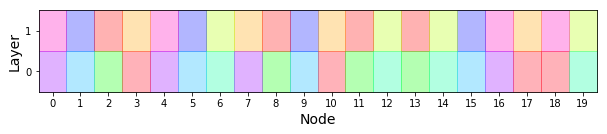

In [1476]:
cols = get_cols(partition_true, randomize=True)

plt.figure(figsize=(10, 1.5))
ax = plt.subplot(1, 1, 1)

for l_n, c in partition_true.items():
    l, n = map(int, l_n.split("_"))
    rect = mpatches.Rectangle([n, l], 1, 1, ec="none", lw=0)
    collection = PatchCollection([rect], color=cols[partition_true["%d_%d" % (l, n)]], alpha=0.3)
    ax.add_collection(collection)

plt.xlim(0, N)
plt.ylim(0, L)

plt.xticks(np.arange(0, N) + 0.5, range(N))
plt.yticks(np.arange(0, L) + 0.5, range(L))

plt.xlabel("Node", fontsize=14)
plt.ylabel("Layer", fontsize=14)

plt.show()

## Compute partition

In [1182]:
layer_communities_true = inflate_layer_partition(partition_true)

In [1177]:
temporal_edgelist = []
for l, partition in layer_communities_true.items():
    for c, nodes in partition.items():
        temporal_edgelist.extend(
            [
                (a, b, l)
                for a, b in generate_connected_graph(nodes)
            ]
        )

temporal_edgelist = pd.DataFrame(temporal_edgelist, columns=["node1", "node2", "layer"])

In [1178]:
network_pajek = ulf.write_pajek(temporal_edgelist)

In [1179]:
random_FC = np.random.randint(0, 1000000)

communities_FC, layer_communities_FC, node_flow_FC, community_flow_FC = ulf.Infomap(
    network_pajek,
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '-z',
    '--two-level',
    'pid%d' % random_FC
)

random_NFC = np.random.randint(0, 1000000)

communities_NFC, layer_communities_NFC, node_flow_NFC, community_flow_NFC = ulf.Infomap(
    network_pajek,
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '-z',
    '--two-level',
    'pid%d' % random_NFC
)

### Estimate accuracy

In [1180]:
print "NFC"
print "Signal layers:",
print NMI_score(
    flatten_layer_partition(layer_communities_NFC, every_other=True),
    flatten_layer_partition(layer_communities_true, every_other=True)
)
print "All layers:",
print NMI_score(
    flatten_layer_partition(layer_communities_NFC, every_other=False),
    flatten_layer_partition(layer_communities_true, every_other=False)
)

NFC
Signal layers: 1.0
All layers: 1.0


In [1181]:
print "FC"
print "Signal layers:",
print NMI_score(
    flatten_layer_partition(layer_communities_FC, every_other=True),
    flatten_layer_partition(layer_communities_true, every_other=True)
)
print "All layers:",
print NMI_score(
    flatten_layer_partition(layer_communities_FC, every_other=False),
    flatten_layer_partition(layer_communities_true, every_other=False)
)

FC
Signal layers: 1.0
All layers: 1.0


# **Results**

In [275]:
def overlap_benchmark_model(N, C, d=1, swaps=50):
    """Create an instance of the overlap benchmark model.
    """
    # Create both layers, initially identical
    first_layer = np.array_split(ulf.shuffle_list(range(N)), C)
    second_layer = copy.deepcopy(first_layer)

    # Perform 1-50 edge swaps in the second layer graph
    for _ in range(np.random.randint(1, swaps)):
        a, b = random.sample(range(C), 2)
        a_i, b_i = random.choice(range(len(second_layer[a]))), random.choice(range(len(second_layer[b])))
        a_v, b_v = second_layer[a][a_i], second_layer[b][b_i]
        second_layer[a][a_i] = b_v; second_layer[b][b_i] = a_v

    # Produce multilayer state node label map
    partition_true = defaultdict(lambda: defaultdict(list))
    for l, layer in enumerate([first_layer] + [second_layer] * ((d-1)*2 + 1)):
        for c, nodes in enumerate(layer):
            for n in nodes:
                partition_true[l][(l * C) % (2*C) + c].append(n)
                
    return ulf.default_to_regular(partition_true)

## Performance vs. AMI

In [325]:
N = 500
C = 50

#x2 = defaultdict(lambda: defaultdict(list))

for _iter in range(1000):

    # Create partition
    partition_true = overlap_benchmark_model(N, C, 1, swaps=500)
    network_pajek = write_pajek(partition_true)

    random_FC = np.random.randint(0, 1000000)

    communities_FC, partition_FC, node_flow_FC, community_flow_FC = ulf.Infomap(
        network_pajek,
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%d' % random_FC
    )

    random_NFC = np.random.randint(0, 1000000)

    communities_NFC, partition_NFC, node_flow_NFC, community_flow_NFC = ulf.Infomap(
        network_pajek,
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%d' % random_NFC
    )

    score_NFC = NMI_score(
        flatten_layer_partition(partition_NFC, every_other=False),
        flatten_layer_partition(partition_true, every_other=False)
    )

    score_FC = NMI_score(
        flatten_layer_partition(partition_FC, every_other=False),
        flatten_layer_partition(partition_true, every_other=False)
    )

    x2[compute_average_mutual_info(partition_true, N)[0]]['NFC'].append(score_NFC)
    x2[compute_average_mutual_info(partition_true, N)[0]]['FC'].append(score_FC)

    if _iter % 10 == 0:
        print _iter

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [326]:
def get_x_y1_y2_from_xn(xn):
    x, y1, y2 = [], [], []
    for x_val, data in xn.items():
        x += [x_val] * len(data['NFC'])
        y1.extend(data['NFC'])
        y2.extend(data['FC'])
    return x, y1, y2

x_B, y1, y2 = get_x_y1_y2_from_xn(x2)

Y1, Y2 = [], []
for _ in range(100):
    # Get bootstrapped data
    x_Bb, y1b, y2b = map(list, zip(*ulf.bootstrap(np.array(zip(x_B, y1, y2))).tolist()))
    
    # Compute smoothened curves from bs data and add to array
    x_B_smooth, y1_smooth = ulf.window_kernel_smoothener(x_Bb, y1b, sigma=0.05, window=10., ticks=100, domain=[min(x_B), max(x_B)])
    x_B_smooth, y2_smooth = ulf.window_kernel_smoothener(x_Bb, y2b, sigma=0.05, window=10., ticks=100, domain=[min(x_B), max(x_B)])
    Y1.append(y1_smooth); Y2.append(y2_smooth)
    
Y1_smooth, Y2_smooth = np.array(Y1), np.array(Y2)
Y1_smooth.sort(0); Y2_smooth.sort(0)

m = ulf.domain_range([min(x_B_smooth), max(x_B_smooth)])
x_B_smooth_adj = [float(m(v)) for v in x_B_smooth]

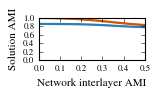

In [328]:
confidence = 0.98
margin_index = int(Y1_smooth.shape[0] * (1. - confidence) / 2)
Y1_smooth_min = Y1_smooth[margin_index, :]
Y1_smooth_max = Y1_smooth[Y1_smooth.shape[0] - margin_index, :]
Y1_smooth_mean = Y1_smooth.mean(0)
Y2_smooth_min = Y2_smooth[margin_index, :]
Y2_smooth_max = Y2_smooth[Y2_smooth.shape[0] - margin_index, :]
Y2_smooth_mean = Y2_smooth.mean(0)

plt.figure(figsize=(3.42/2.0, 1.2/1.8), frameon=False)

plt.fill_between(x_B_smooth_adj, Y1_smooth_min, Y1_smooth_max, alpha=0.5, color="#d35400")
plt.plot(x_B_smooth_adj, Y1_smooth_mean, color="#d35400", lw=2)

plt.fill_between(x_B_smooth_adj, Y2_smooth_min, Y2_smooth_max, alpha=0.5, color="#2980b9")
plt.plot(x_B_smooth_adj, Y2_smooth_mean, color="#2980b9", lw=2)

plt.xlim(0, 0.5)
plt.ylim(0.0, 1.0)

#plt.yticks(np.linspace(0.6, 1.0, 5))

plt.xlabel("Network interlayer AMI")
plt.ylabel("Solution AMI")

#plt.savefig("figures/AMIvsAMIN20C5_01_narrow.pdf")

## Alt. performance vs. AMI

In [253]:
N = 500
C = 50

X3 = {}
for L in range(1, 2, 1):
    #x3 = defaultdict(lambda: defaultdict(list))

    for _ in range(1000):

        # Create partition
        partition_true = overlap_benchmark_model(N, C, L)
        
        # Compute communities and estimate quality
        layer_communities_true = inflate_layer_partition(partition_true)

        temporal_edgelist = []
        for l, partition in layer_communities_true.items():
            for c, nodes in partition.items():
                temporal_edgelist.extend(
                    [
                        (a, b, l)
                        for a, b in generate_connected_graph(nodes)
                    ]
                )

        temporal_edgelist = pd.DataFrame(temporal_edgelist, columns=["node1", "node2", "layer"])
        network_pajek = ulf.write_pajek(temporal_edgelist)

        random_FC = np.random.randint(0, 1000000)
        communities_FC, layer_communities_FC, node_flow_FC, community_flow_FC = Infomap(
            network_pajek,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '-z',
            '--two-level',
            'pid%d' % random_FC
        )

        random_NFC = np.random.randint(0, 1000000)
        communities_NFC, layer_communities_NFC, node_flow_NFC, community_flow_NFC = Infomap(
            network_pajek,
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '-z',
            '--two-level',
            'pid%d' % random_NFC
        )
        
        independent_AMI = compute_average_mutual_info2(inflate_layer_partition(partition_true), N)[0]

        score_NFC = abs(
            independent_AMI - compute_average_mutual_info2(layer_communities_NFC, N)[0]
        )

        score_FC = abs(
            independent_AMI - compute_average_mutual_info2(layer_communities_FC, N)[0]
        )

        x3[independent_AMI]['NFC'].append(score_NFC)
        x3[independent_AMI]['FC'].append(score_FC)
        
    X3[L] = x3

NameError: name 'Infomap' is not defined

In [2950]:
def get_x_y1_y2_from_xn(xn):
    x, y1, y2 = [], [], []
    for x_val, data in xn.items():
        x += [x_val] * len(data['NFC'])
        y1.extend(data['NFC'])
        y2.extend(data['FC'])
    return x, y1, y2

x_B, y1, y2 = get_x_y1_y2_from_xn(X3[1])

Y1, Y2 = [], []
for _ in range(100):
    # Get bootstrapped data
    x_Bb, y1b, y2b = map(list, zip(*ulf.bootstrap(np.array(zip(x_B, y1, y2))).tolist()))
    
    # Compute smoothened curves from bs data and add to array
    x_B_smooth, y1_smooth = ulf.window_kernel_smoothener(x_Bb, y1b, sigma=0.05, window=10., ticks=100, domain=[min(x_B), max(x_B)])
    x_B_smooth, y2_smooth = ulf.window_kernel_smoothener(x_Bb, y2b, sigma=0.05, window=10., ticks=100, domain=[min(x_B), max(x_B)])
    Y1.append(y1_smooth); Y2.append(y2_smooth)
    
Y1_smooth, Y2_smooth = np.array(Y1), np.array(Y2)
Y1_smooth.sort(0); Y2_smooth.sort(0)

m = ulf.domain_range([min(x_B_smooth), max(x_B_smooth)])
x_B_smooth_adj = [float(m(v)) for v in x_B_smooth]

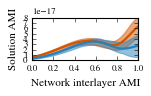

In [2951]:
confidence = 0.99
margin_index = int(Y1_smooth.shape[0] * (1. - confidence) / 2)
Y1_smooth_min = Y1_smooth[margin_index, :]
Y1_smooth_max = Y1_smooth[Y1_smooth.shape[0] - margin_index - 1, :]
Y1_smooth_mean = Y1_smooth.mean(0)
Y2_smooth_min = Y2_smooth[margin_index, :]
Y2_smooth_max = Y2_smooth[Y2_smooth.shape[0] - margin_index - 1, :]
Y2_smooth_mean = Y2_smooth.mean(0)

plt.figure(figsize=(3.42/2.0, 1.2/1.8), frameon=False)

plt.fill_between(x_B_smooth_adj, Y1_smooth_min, Y1_smooth_max, alpha=0.5, color="#d35400")
plt.plot(x_B_smooth_adj, Y1_smooth_mean, color="#d35400", lw=2)

plt.fill_between(x_B_smooth_adj, Y2_smooth_min, Y2_smooth_max, alpha=0.5, color="#2980b9")
plt.plot(x_B_smooth_adj, Y2_smooth_mean, color="#2980b9", lw=2)

plt.xlim(0, 1)
#plt.ylim(0, 0.1)

#plt.yticks(np.linspace(0.6, 1.0, 5))

plt.xlabel("Network interlayer AMI")
plt.ylabel("Solution AMI")

#plt.savefig("figures/AMIvsAMIN20C5_01_narrow.pdf")

## Merge proba. vs. overlap

In [262]:
def com_match(nodes_i, nodes_j, layer_communities_sol):
    def _get_com(nodes_x, l):
        sim = dict()
        for c, nodes in layer_communities_sol[l].items():
            sim[c] = len(set(nodes_x) & set(nodes))
        return max(sim.items(), key=lambda (k, v): v)[0]
    return _get_com(nodes_i, 0) == _get_com(nodes_j, 1)

def compute_overlap_and_merge(layer_communities_true, layer_communities_sol):
    overlap, merge = [], []
    for c_i, nodes_i in layer_communities_true[0].items():
        for c_j, nodes_j in layer_communities_true[1].items():
            overlap.append(len(set(nodes_i) & set(nodes_j)))
            merge.append(com_match(nodes_i, nodes_j, layer_communities_sol))
    return overlap, merge

def to_sparse_temporal_edgelist(layer_communities_true, sparse_frac):
    num_e = lambda n: n * (n-1) / 2.0 * sparse_frac
    temporal_edgelist = []
    for l, partition in layer_communities_true.items():
        for c, nodes in partition.items():
            temporal_edgelist.extend(
                [
                    (a, b, l)
                    for a, b in ulf.shuffle_list(generate_connected_graph(nodes))[:int(num_e(len(nodes)))]
                ]
            )

    return pd.DataFrame(temporal_edgelist, columns=["node1", "node2", "layer"])

In [348]:
N = 500
C = 50
sparse_frac = 0.5

overlap_FC, merge_FC = [], []
overlap_NFC, merge_NFC = [], []
    
for _itr in range(100):

    # Create partition
    partition_true = overlap_benchmark_model(N, C, swaps=2000)
    network_pajek = write_pajek(partition_true, sparse_frac=sparse_frac)
    
    random_FC = np.random.randint(0, 1000000)
    communities_FC, partition_FC, node_flow_FC, community_flow_FC = ulf.Infomap(
        network_pajek,
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.3',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '-z',
        '--two-level',
        'pid%d' % random_FC
    )

    random_NFC = np.random.randint(0, 1000000)
    communities_NFC, partition_NFC, node_flow_NFC, community_flow_NFC = ulf.Infomap(
        network_pajek,
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.3',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '-z',
        '--two-level',
        'pid%d' % random_NFC
    )
    
    # Compute overlap and merge
    overlap_FC_iter, merge_FC_iter = compute_overlap_and_merge(partition_true, partition_FC) 
    overlap_NFC_iter, merge_NFC_iter = compute_overlap_and_merge(partition_true, partition_NFC) 
    
    overlap_FC.extend(overlap_FC_iter)
    merge_FC.extend(merge_FC_iter)
    overlap_NFC.extend(overlap_NFC_iter)
    merge_NFC.extend(merge_NFC_iter)
    print _itr,


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [349]:
ds_FC = defaultdict(list)
for o, m in zip(overlap_FC, merge_FC):
    ds_FC[o].append(m)
ds_NFC = defaultdict(list)
for o, m in zip(overlap_NFC, merge_NFC):
    ds_NFC[o].append(m)

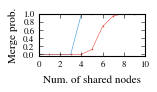

In [351]:
plt.figure(figsize=(3.42/2, 1.2/1.8), frameon=False)

x_FC, y_FC, e_FC, c_FC = zip(*sorted([(k, np.mean(v), np.std(v) / np.sqrt(len(v)), len(v)) for k, v in ds_FC.items()], key=lambda vals: vals[0]))
plt.plot(x_FC, y_FC, c="#3498db", lw=0.5)
plt.scatter(x_FC, y_FC, c="#3498db", lw=0, s=2)
x_NFC, y_NFC, e_NFC, c_NFC = zip(*sorted([(k, np.mean(v), np.std(v) / np.sqrt(len(v)), len(v)) for k, v in ds_NFC.items()], key=lambda vals: vals[0]))
plt.plot(x_NFC, y_NFC, c="#e74c3c", lw=0.5)
plt.scatter(x_NFC, y_NFC, c="#e74c3c", lw=0, s=2)

plt.xlabel("Num. of shared nodes")
plt.ylabel("Merge prob.")
plt.xlim(0, N/C)
plt.ylim(-0.05, 1.0)

plt.savefig("figures/merge_vs_shared_overlap_sparse05.pdf")
plt.show()

## Two overlapping communities

Not showing anything very strongly

### Dense

In [257]:
def two_overlap_benchmark_model(N, m):
    """Create two communities of size `N` that overlap by `m` nodes.

    Two communities each contain `N` nodes and overlap my `m` nodes. All
    nodes in one layer are connected and we stack layers vertically. Examples:

    N=5, m=1:          |  N=5, m=2:        |  N=3, m=2
            o o o o o  |        o o o o o  |    o o o
    o o o o o          |  o o o o o        |  o o o

    Input
    -----
    N : int
        Number of nodes in each community
    m : int
        Number of overlapping nodes between the two communities
    """
    # Create both layers, initially identical
    first_layer = np.arange(0, N)
    second_layer = np.arange(N-m, 2*N - m)

    # Produce multilayer state node label map
    partition = defaultdict(lambda: defaultdict(list))
    for l, nodes in enumerate([first_layer, second_layer]):
        for n in nodes:
            partition[l][l].append(n)

    return ulf.default_to_regular(partition)

def write_pajek(layer_partition, sparse_frac=1):
    """Create pajek file from layer partition."""
    network = "*Vertices "

    nodes = set(
        n
        for l, partition in layer_partition.items()
        for c, nodes in partition.items()
        for n in nodes
    )

    network += str(len(nodes))

    for n in sorted(nodes):
        network += '\n%d "%d" 1.0' % (n, n)

    network += "\n*Intra\n#layer node node [weight]"

    for l, partition in layer_partition.items():
        for c, nodes in partition.items():
            links = generate_connected_graph(nodes)
            for a, b in ulf.shuffle_list(links)[:int(len(links)*sparse_frac)]:
                network += "\n%d %d %d 1.0" % (l, a, b)

    return network

In [93]:
num_e = lambda n: n * (n-1) / 2.0

sparse_frac = 0.5

dataN = defaultdict(dict)
for N in range(10, 200, 10):
    
    print 
    print "N =", N, "\n    m =",
    
    run_NFC, run_FC = True, True
    for m in range(N/3-N/10, N):
    
        print m, 
        
        # Create partition
        two_layer_partition = two_overlap_benchmark_model(N, m)
        network_pajek = write_pajek(two_layer_partition, sparse_frac=sparse_frac)

        if run_NFC:
            def _get_layer_layer_communities_NFC():
                random_NFC = np.random.randint(0, 1000000)
                return ulf.Infomap(
                    network_pajek,
                    '-i',
                    'multiplex',
                    '--multiplex-js-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '-z',
                    '--two-level',
                    'pid%d' % random_NFC
                )[1]
            
            layer_communities_NFC = _get_layer_layer_communities_NFC ()
            if layer_communities_NFC[0].keys()[0] == layer_communities_NFC[1].keys()[0]:
                print "(NFC)",
                run_NFC = False
                dataN[N]['NFC'] = (m * 1.0 / (N - m), num_e(m) / (2 * num_e(N) - num_e(m)))

        if run_FC:
            @ulf.keeptrying(Exception)
            def _get_layer_layer_communities_FC():
                random_FC = np.random.randint(0, 1000000)
                layer_communities_FC = ulf.Infomap(
                    network_pajek,
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '-z',
                    '--two-level',
                    'pid%d' % random_FC
                )[1]
                
                if layer_communities_FC == {}:
                    raise Exception
                
                return layer_communities_FC
            
            layer_communities_FC = _get_layer_layer_communities_FC()
            if layer_communities_FC[0].keys()[0] == layer_communities_FC[1].keys()[0]:
                print "(FC)",
                run_FC = False
                dataN[N]['FC'] = (m * 1.0 / (N - m), num_e(m) / (2 * num_e(N) - num_e(m)))
        
        if not run_NFC and not run_FC:
            break



N = 10 
    m = 2 3 4 (NFC) (FC)
N = 20 
    m = 4 5 6 (NFC) (FC)
N = 30 
    m = 7 8 9 (NFC) (FC)
N = 40 
    m = 9 10 11 (FC) 12 13 (NFC)
N = 50 
    m = 11 12 13 14 15 (NFC) (FC)
N = 60 
    m = 14 15 16 17 (FC) 18 (NFC)
N = 70 
    m = 16 17 18 19 (FC) 20 21 22 (NFC)
N = 80 
    m = 18 19 20 21 22 23 24 (FC) 25 (NFC)
N = 90 
    m = 21 22 23 24 25 26 (FC) 27 (NFC)
N = 100 
    m = 23 24 25 26 27 28 (NFC) 29 30 (FC)
N = 110 
    m = 25 26 27 28 29 (FC) 30 31 32 33 (NFC)
N = 120 
    m = 28 29 30 31 32 33 34 (FC) 35 36 37 (NFC)
N = 130 
    m = 30 31 32 33 34 35 36 37 38 (NFC) (FC)
N = 140 
    m = 32 33 34 35 36 37 38 39 (FC) 40 (NFC)
N = 150 
    m = 35 36 37 38 39 40 41 42 (FC) 43 44 (NFC)
N = 160 
    m = 37 38 39 40 41 42 43 44 45 46 47 (NFC) (FC)
N = 170 
    m = 39 40 41 42 43 44 45 46 47 48 (NFC) (FC)
N = 180 
    m = 42 43 44 45 46 47 48 49 50 (NFC) (FC)
N = 190 
    m = 44 45 46 47 48 49 50 51 52 53 54 (FC) 55 (NFC)


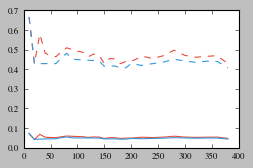

In [67]:
x, y_NFC_n, y_NFC_e, y_FC_n, y_FC_e = [], [], [], [], []
for N, data in sorted(dataN.items(), key=lambda (k, v): k):    
    x.append(N)
    y_NFC_n.append(data['NFC'][0])
    y_NFC_e.append(data['NFC'][1])
    y_FC_n.append(data['FC'][0])
    y_FC_e.append(data['FC'][1])
a
plt.figure()

plt.plot(x, y_NFC_n, c="#e74c3c", ls="--")
plt.plot(x, y_NFC_e, c="#e74c3c", ls="-")

plt.plot(x, y_FC_n, c="#3498db", ls="--")
plt.plot(x, y_FC_e, c="#3498db", ls="-")

plt.show()

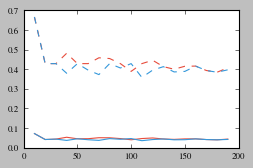

In [95]:
x, y_NFC_n, y_NFC_e, y_FC_n, y_FC_e = [], [], [], [], []
for N, data in sorted(dataN.items(), key=lambda (k, v): k):    
    x.append(N)
    y_NFC_n.append(data['NFC'][0])
    y_NFC_e.append(data['NFC'][1])
    y_FC_n.append(data['FC'][0])
    y_FC_e.append(data['FC'][1])
a
plt.figure()

plt.plot(x, y_NFC_n, c="#e74c3c", ls="--")
plt.plot(x, y_NFC_e, c="#e74c3c", ls="-")

plt.plot(x, y_FC_n, c="#3498db", ls="--")
plt.plot(x, y_FC_e, c="#3498db", ls="-")

plt.show()

### Sparse

In [8]:
def two_overlap_benchmark_model(N, m, d=1):
    """Create an instance of the two communities overlap benchmark model.
    
    Input
    -----
    N : int
        Number of nodes in each community
    m : int
        Number of overlapping nodes between the two communities
    """
    # Create both layers, initially identical
    first_layer = np.arange(0, N)
    second_layer = np.arange(N-m, 2*N - m)

    # Produce multilayer state node label map
    partition_true = {}
    for l, nodes in enumerate([first_layer, second_layer] * d):
        for n in nodes:
            partition_true[str(l) + "_" + str(n)] = l
                
    return partition_true

In [2850]:
sparse_frac = 0.1
num_e = lambda n: n * (n-1) / 2.0 * sparse_frac

dataN_sparse = defaultdict(dict)
for N in range(10, 200, 10):
    
    print 
    print "N =", N, "\n    m =",
    
    run_NFC, run_FC = True, True
    for m in range(N/3-N/10, N):
    
        print m, 
        
        # Create partition
        partition_true = two_overlap_benchmark_model(N, m, 1)

        # Compute communities and estimate quality
        layer_communities_true = inflate_layer_partition(partition_true)

        # Convert to temporal edgelist
        temporal_edgelist = []
        for l, partition in layer_communities_true.items():
            for c, nodes in partition.items():
                temporal_edgelist.extend(
                    [
                        (a, b, l)
                        for a, b in ulf.shuffle_list(generate_connected_graph(nodes))[:int(num_e(N))]
                    ]
                )
        temporal_edgelist = pd.DataFrame(temporal_edgelist, columns=["node1", "node2", "layer"])
        
        # Convert to pajek
        network_pajek = ulf.write_pajek(temporal_edgelist)

        if run_NFC:
            def _get_layer_layer_communities_NFC():
                random_NFC = np.random.randint(0, 1000000)
                return ulf.Infomap(
                    network_pajek,
                    '-i',
                    'multiplex',
                    '--multiplex-js-relax-rate', '0.25',
                    '--overlapping',
                    '--multiplex-add-missing-nodes',
                    '--expanded',
                    '--clu',
                    '-z',
                    '--two-level',
                    'pid%d' % random_NFC
                )[1]
            
            layer_communities_NFC = _get_layer_layer_communities_NFC ()
            if layer_communities_NFC[0].keys()[0] == layer_communities_NFC[1].keys()[0]:
                print "(NFC)",
                run_NFC = False
                dataN_sparse[N]['NFC'] = (m * 1.0 / (2 * N - m), num_e(m) / (2 * num_e(N) - num_e(m)))

        if run_FC:
            @ulf.keeptrying(Exception)
            def _get_layer_layer_communities_FC():
                random_FC = np.random.randint(0, 1000000)
                _, layer_communities_FC, _, _ = ulf.Infomap(
                    network_pajek,
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--overlapping',
                    '--multiplex-add-missing-nodes',
                    '--expanded',
                    '--clu',
                    '-z',
                    '--two-level',
                    'pid%d' % random_FC
                )

                if layer_communities_FC == {}:
                    raise Exception

                # Filter dead nodes from FC
                nodes_l = dict(
                    (l, c_nodes.values()[0])
                    for l, c_nodes in layer_communities_true.items()
                )

                tmp = defaultdict(lambda: defaultdict(list))
                for l, c_nodes in layer_communities_FC.items():
                    for c, nodes in c_nodes.items():
                        if len(set(nodes) & set(nodes_l[l])) != 0:
                            tmp[l][c].extend([n for n in nodes if n in nodes_l[l]])

                return ulf.default_to_regular(tmp)
            
            layer_communities_FC = _get_layer_layer_communities_FC()
            if layer_communities_FC[0].keys()[0] == layer_communities_FC[1].keys()[0]:
                print "(FC)",
                run_FC = False
                dataN_sparse[N]['FC'] = (m * 1.0 / (2 * N - m), num_e(m) / (2 * num_e(N) - num_e(m)))
        
        if not run_NFC and not run_FC:
            break



N = 10 
    m = 2 (FC) 3 4 5 6 7 8 9
N = 20 
    m = 4 5 6 7 8 9 (FC) 10 11 (NFC)
N = 30 
    m = 7 8 (FC) 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 (NFC)
N = 40 
    m = 9 10 11 12 13 14 15 16 17 18 19 20 21 22 (FC) 23 24 25 26 27 28 29 30 31 32 (NFC)
N = 50 
    m = 11 12 13 14 15 16 17 18 19 (FC) 20 21 22 23 24 25 26 27 28 (NFC)
N = 60 
    m = 14 15 16 17 18 19 20 21 22 23 24 25 26 (FC) 27 28 29 30 31 32 33 (NFC)
N = 70 
    m = 16 17 18 19 20 21 22 23 24 25 26 27 28 (FC) 29 30 31 32 33 34 35 36 37 38 39 40 (NFC)
N = 80 
    m = 18 19 20 21 22 23 24 25 26 27 28 29 (FC) 30 (NFC)
N = 90 
    m = 21 22 23 24 25 26 27 (NFC) 28 29 30 31 32 33 34 35 36 37 38 39 (FC)
N = 100 
    m = 23 24 25 26 27 28 29 (NFC) 30 (FC)
N = 110 
    m = 25 26 27 28 29 30 31 32 (FC) 33 34 35 (NFC)
N = 120 
    m = 28 29 30 31 32 33 34 35 (NFC) 36 37 (FC)
N = 130 
    m = 30 31 32 33 34 35 36 37 38 (NFC) (FC)
N = 140 
    m = 32 33 34 35 36 37 38 (FC) 39 40 (NFC)
N = 150 
    m = 35 36 37 38 39 40 41 42 (N

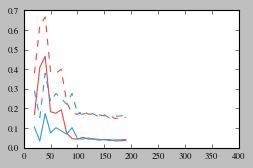

In [2854]:
x, y_NFC_n, y_NFC_e, y_FC_n, y_FC_e = [], [], [], [], []
for N, data in sorted(dataN_sparse.items(), key=lambda (k, v): k):    
    if 'FC' not in data or 'NFC' not in data:
        continue
    x.append(N)
    y_NFC_n.append(data['NFC'][0])
    y_NFC_e.append(data['NFC'][1])
    y_FC_n.append(data['FC'][0])
    y_FC_e.append(data['FC'][1])

plt.figure()

plt.plot(x, y_NFC_n, c="#e74c3c", ls="--")
plt.plot(x, y_NFC_e, c="#e74c3c", ls="-")

plt.plot(x, y_FC_n, c="#3498db", ls="--")
plt.plot(x, y_FC_e, c="#3498db", ls="-")

plt.xlim(0, 400)

plt.show()

### Transition probability

In [9]:
def two_overlap_benchmark_model(N, m, d=1):
    """Create an instance of the two communities overlap benchmark model.
    
    Input
    -----
    N : int
        Number of nodes in each community
    m : int
        Number of overlapping nodes between the two communities
    """
    # Create both layers, initially identical
    first_layer = np.arange(0, N)
    second_layer = np.arange(N-m, 2*N - m)

    # Produce multilayer state node label map
    partition_true = {}
    for l, nodes in enumerate([first_layer, second_layer] * d):
        for n in nodes:
            partition_true[str(l) + "_" + str(n)] = l
                
    return partition_true

In [505]:
sparse_frac = 1.0

N = 10
deltas = np.linspace(1.0/N, 1, N)
ms = N * deltas

num_e = lambda n: n * (n-1) / 2.0 * sparse_frac

# Create partition
partition_true = two_overlap_benchmark_model(N, m, 1)

# Compute communities and estimate quality
layer_communities_true = inflate_layer_partition(partition_true)

# Convert to temporal edgelist
temporal_edgelist = pd.DataFrame(columns=["node1", "node2", "layer"]).astype(int)
for l, partition in layer_communities_true.items():
    for c, nodes in partition.items():
        temporal_edgelist = pd.concat([
            temporal_edgelist, 
            pd.DataFrame([
                (a, b, l)
                for a, b in ulf.shuffle_list(generate_connected_graph(nodes))[:int(num_e(N))]
            ], columns=["node1", "node2", "layer"])
        ])
        
# Convert to pajek
network_pajek = ulf.write_pajek(temporal_edgelist)

# Compute NFC
def run_NFC(seed):
    return ulf.Infomap(
        network_pajek,
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.25',
        '--overlapping',
        '--multiplex-add-missing-nodes',
        '--expanded',
        '--pajek',
        '--clu',
        '-z',
        '--two-level',
        'pid%d' % seed
    )

random_NFC = np.random.randint(0, 1000000)
a, b, c, d = run_NFC(random_NFC)

with open("/tmp/output_infomap/tmpnet%d.net" % random_NFC) as fp:
    pajek_NFC = fp.read()
    subprocess.call(["rm", "/tmp/output_infomap/tmpnet%d.net" % random_NFC])

In [506]:
c

{'0_0': 0.0911458,
 '0_1': 0.0911458,
 '0_2': 0.0911458,
 '0_3': 0.0911458,
 '0_4': 0.09375,
 '0_5': 0.0104167,
 '0_6': 0.0104167,
 '0_7': 0.0104167,
 '0_8': 0.0104167,
 '1_0': 0.0104167,
 '1_1': 0.0104167,
 '1_2': 0.0104167,
 '1_3': 0.0104167,
 '1_4': 0.09375,
 '1_5': 0.0911458,
 '1_6': 0.0911458,
 '1_7': 0.0911458,
 '1_8': 0.0911458}

In [443]:
[
    l
    for l in re.findall(r"\d+ \d+ \d+ \d+ \d.*\d*", pajek_NFC)
    if l.split()[0] != l.split()[2]
]

[]

In [489]:
N = 5
m = 1

num_e = lambda n: n * (n-1) / 2.0 * sparse_frac

# Create partition
partition_true = two_overlap_benchmark_model(N, m)

# Compute communities and estimate quality
layer_communities_true = inflate_layer_partition(partition_true)

# Convert to temporal edgelist
temporal_edgelist = pd.DataFrame(columns=["node1", "node2", "layer"]).astype(int)
for l, partition in layer_communities_true.items():
    for c, nodes in partition.items():
        temporal_edgelist = pd.concat([
            temporal_edgelist, 
            pd.DataFrame([
                (a, b, l)
                for a, b in ulf.shuffle_list(generate_connected_graph(nodes))[:int(num_e(N))]
            ], columns=["node1", "node2", "layer"])
        ])
        
# Convert to pajek
network_pajek = ulf.write_pajek(temporal_edgelist)

In [494]:
with open("fc_example/network.net", 'w') as fp:
    fp.write(network_pajek)

In [493]:
mkdir fc_example